In [84]:
# Enhanced CTR Modeling with Classification and Clicks/Impressions Ratio

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
import joblib

In [85]:
# Load your cleaned and encoded DataFrame
df = pd.read_csv("../data/meta_ads_cleaned.csv")
df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0281 - Campagne Ramadan - Instagram - ...,inactive,Instagram,In-app,Feed,Awareness,reach,0.28,Using ad set budget,0.28,...,0.000000,0,0.0,0.00,0,0.0,0.000000,0,0.000000,0.00
1,SO/2024/0318 - Campagne Ramadan 2 - BC : - In...,not_delivering,Audience Network,In-app,Feed,App Installs,actions:mobile_app_install,2.63,Using ad set budget,2.63,...,2.630000,0,0.0,0.00,0,0.0,0.000000,0,0.000000,0.00
2,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,Feed,Sales,actions:offsite_conversion.fb_pixel_purchase,22.80,Using ad set budget,22.80,...,0.000000,60,1199.0,0.38,730,1756.0,0.031233,228,0.100000,4.56
3,SO/2024/0318 - Campagne Ramadan 2 - BC : - In...,not_delivering,Audience Network,In-app,Facebook Stories,App Installs,actions:mobile_app_install,25.83,Using ad set budget,25.83,...,0.993462,0,0.0,0.00,3,0.0,8.610000,0,0.000000,0.00
4,SO/2024/0556 - Orange - Lancement_campagne_Dat...,not_delivering,Instagram,Desktop,Feed,Awareness,reach,191.10,Using ad set budget,191.10,...,0.000000,5,0.0,38.22,103,0.0,1.855340,32,5.971875,0.00


In [86]:
traffic_df = df[df['Objective'] == 'Traffic'].copy()
traffic_df.reset_index(drop=True, inplace=True)
traffic_df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0884 - Orange - Lancement posts digita...,not_delivering,Instagram,Desktop,Feed,Traffic,actions:link_click,4505.81,Using ad set budget,4505.81,...,2.114411,243,71647.6,18.542428,3468,1788.29,1.299253,5850,0.770224,1501.936667
1,SO/2025/0206 Orange - Lancement posts digitaux...,active,Audience Network,Desktop,"Native, banner & interstitial",Traffic,actions:link_click,475.32,Using ad set budget,475.32,...,2.353069,111,249.0,4.282162,802,0.00,0.592668,13547,0.035087,475.320000
2,SO/2024/0582 - Orange - Campagne achat et rech...,not_delivering,Audience Network,In-app,"Native, banner & interstitial",Traffic,actions:link_click,577.18,Using ad set budget,577.18,...,0.000000,14,0.0,41.227143,427,0.00,1.351710,2759,0.209199,577.180000
3,SO/2023/0333 - Orange - Campagne caravane Bal...,not_delivering,Facebook,In-app,Facebook Reels,Traffic,actions:link_click,368.26,Using ad set budget,368.26,...,0.000000,3,755.1,122.753333,23,0.00,16.011304,2,184.130000,0.000000
4,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,"Native, banner & interstitial",Traffic,actions:link_click,3006.70,Using ad set budget,3006.70,...,0.873279,1023,59950.0,2.939101,8444,277.50,0.356075,160516,0.018731,150.335000


In [87]:
categorical_cols = ['Platforme', 'Placement', 'Device', 'Ad set budget type']

traffic_df_encoded = pd.get_dummies(traffic_df, columns=categorical_cols, drop_first=True)

# --- Step 1.5: Add Date Features (if available)
if 'Starts' in traffic_df_encoded.columns:
    traffic_df_encoded['Starts'] = pd.to_datetime(traffic_df_encoded['Starts'])
    traffic_df_encoded['day'] = traffic_df_encoded['Starts'].dt.day
    traffic_df_encoded['month'] = traffic_df_encoded['Starts'].dt.month
    traffic_df_encoded['weekday'] = traffic_df_encoded['Starts'].dt.weekday
    traffic_df_encoded['year'] = traffic_df_encoded['Starts'].dt.year
traffic_df_encoded.head()

,Campaign name,Campaign Delivery,Objective,Result indicator,Ad set budget,Amount spent,Attribution setting,Date created,Starts,Ends,...,Placement_Facebook profile feed,Placement_Feed,Placement_Instagram Stories,"Placement_Native, banner & interstitial",Device_In-app,Ad set budget type_Using ad set budget,day,month,weekday,year
0,SO/2024/0884 - Orange - Lancement posts digita...,not_delivering,Traffic,actions:link_click,4505.81,4505.81,7-day click or 1-day view,2025-01-14,2025-01-16,2025-03-25 00:00:00,...,False,True,False,False,False,True,16,1,3,2025
1,SO/2025/0206 Orange - Lancement posts digitaux...,active,Traffic,actions:link_click,475.32,475.32,7-day click or 1-day view,2025-03-18,2025-03-18,2025-05-11 00:00:00,...,False,False,False,True,False,True,18,3,1,2025
2,SO/2024/0582 - Orange - Campagne achat et rech...,not_delivering,Traffic,actions:link_click,577.18,577.18,7-day click or 1-day view,2024-08-15,2024-08-15,2024-09-04 00:00:00,...,False,False,False,True,True,True,15,8,3,2024
3,SO/2023/0333 - Orange - Campagne caravane Bal...,not_delivering,Traffic,actions:link_click,368.26,368.26,7-day click or 1-day view,2023-12-27,2023-12-27,2024-01-25 00:00:00,...,False,False,False,False,True,True,27,12,2,2023
4,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Traffic,actions:link_click,3006.70,3006.70,7-day click or 1-day view,2024-08-22,2024-08-22,Ongoing,...,False,False,False,True,True,True,22,8,3,2024


In [88]:
# --- Step 1: Prepare CTR Classes ---
traffic_df_encoded = traffic_df_encoded[traffic_df_encoded['Amount spent'] > 0]
traffic_df_encoded['CTR'] = traffic_df_encoded['CTR (all)']


In [89]:
# Bin CTR into 3 classes: Low, Medium, High
bins = [0, 0.5, 1.5, 3, 5, np.inf]  # adjust as needed
labels = [0, 1, 2, 3, 4,]
traffic_df_encoded['CTR_class'] = pd.cut(traffic_df_encoded['CTR'], bins=bins, labels=labels)

In [91]:
# --- Step 2: Define Feature Set ---
X = traffic_df_encoded.drop(columns=['CTR', 'CTR (all)', 'CTR_class', 'Clicks (all)', 'Impressions','day', 'month', 'weekday', 'year',])

# Drop non-numeric columns from X
non_numeric_cols = X.select_dtypes(include=['object', 'datetime64']).columns
if len(non_numeric_cols) > 0:
    print("Dropping non-numeric columns:", list(non_numeric_cols))
    X = X.drop(columns=non_numeric_cols)

Dropping non-numeric columns: ['Campaign name', 'Campaign Delivery', 'Objective', 'Result indicator', 'Attribution setting', 'Date created', 'Starts', 'Ends', 'Video average play time']


In [92]:
print(X.select_dtypes(include='object').columns)

Index([], dtype='object')


In [93]:
y = traffic_df_encoded['CTR_class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
# --- Step 3: Train classifier ---
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [95]:
# --- Step 4: Evaluate ---
y_pred = clf.predict(X_test)
print("\nCTR Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


CTR Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        13
           2       0.50      0.75      0.60         4
           3       0.00      0.00      0.00         1
           4       1.00      0.33      0.50         3

    accuracy                           0.82        22
   macro avg       0.70      0.62      0.62        22
weighted avg       0.86      0.82      0.81        22

Accuracy: 0.8182


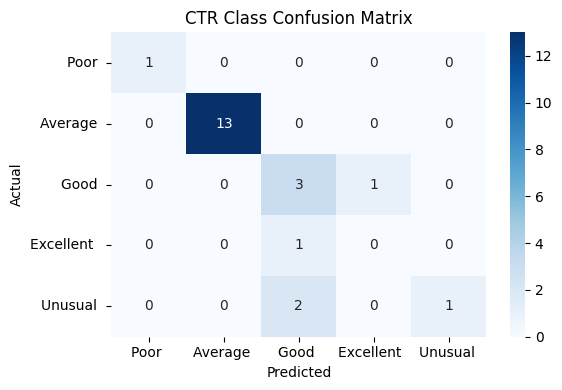

In [96]:
# --- Step 5: Evaluate and Visualize CTR Classification ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor ', 'Average ', 'Good ', 'Excellent  ', 'Unusual '], yticklabels=['Poor ', 'Average ', 'Good ', 'Excellent  ', 'Unusual '])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CTR Class Confusion Matrix")
plt.tight_layout()
plt.show()


In [97]:
# --- Step 5: Save model ---
joblib.dump(clf, 'ctr_classifier.pkl')

['ctr_classifier.pkl']

In [98]:
# --- Step 6: Model CTR as Clicks / Impressions ---
traffic_df_encoded['Clicks_scaled'] = traffic_df_encoded['Clicks (all)'] / (traffic_df_encoded['Amount spent'] / 1000)
traffic_df_encoded['Impr_scaled'] = traffic_df_encoded['Impressions'] / (traffic_df_encoded['Amount spent'] / 1000)

In [99]:
y_clicks = traffic_df_encoded['Clicks_scaled']
y_impr = traffic_df_encoded['Impr_scaled']


In [108]:
X_ratio = traffic_df_encoded.drop(columns=['CTR', 'CTR (all)', 'CTR_class', 'Clicks (all)', 'Impressions', 'Clicks_scaled', 'Impr_scaled', 'day', 'month', 'weekday', 'year'])
X_ratio = X_ratio.drop(columns=X_ratio.select_dtypes(include=['object', 'datetime64']).columns)

In [109]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_ratio, y_clicks, test_size=0.2, random_state=42)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_ratio, y_impr, test_size=0.2, random_state=42)

In [110]:
from sklearn.ensemble import GradientBoostingRegressor
click_model = GradientBoostingRegressor(n_estimators=200, random_state=42)
impr_model = GradientBoostingRegressor(n_estimators=200, random_state=42)


In [111]:
click_model.fit(X_train_c, y_train_c)
impr_model.fit(X_train_i, y_train_i)

GradientBoostingRegressor(n_estimators=200, random_state=42)

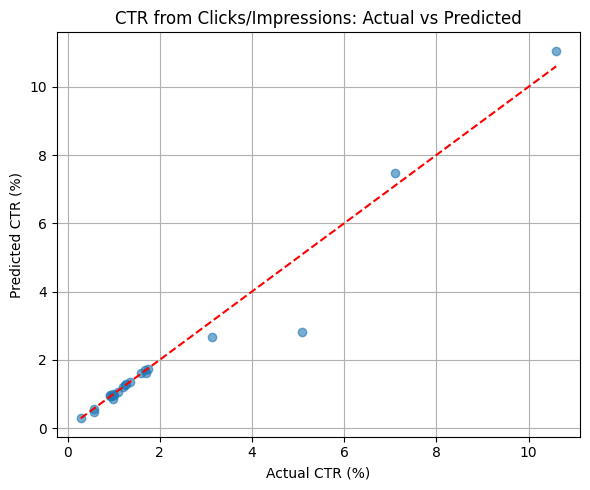

In [112]:
# Evaluate and Visualize CTR as Clicks / Impressions ---

from sklearn.metrics import mean_squared_error, r2_score

click_preds = click_model.predict(X_test_c)
impr_preds = impr_model.predict(X_test_i)

ctr_preds_ratio = (click_preds / impr_preds) * 100
ctr_true_ratio = (y_test_c / y_test_i) * 100

plt.figure(figsize=(6, 5))
plt.scatter(ctr_true_ratio, ctr_preds_ratio, alpha=0.6)
plt.plot([ctr_true_ratio.min(), ctr_true_ratio.max()], [ctr_true_ratio.min(), ctr_true_ratio.max()], 'r--')
plt.xlabel("Actual CTR (%)")
plt.ylabel("Predicted CTR (%)")
plt.title("CTR from Clicks/Impressions: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


In [113]:
ctr_rmse = np.sqrt(mean_squared_error(ctr_true_ratio, ctr_preds_ratio))
ctr_r2 = r2_score(ctr_true_ratio, ctr_preds_ratio)
print(f"CTR Ratio Model - RMSE: {ctr_rmse:.2f}, R²: {ctr_r2:.4f}")

CTR Ratio Model - RMSE: 0.51, R²: 0.9549


In [114]:
joblib.dump(click_model, 'clicks_model.pkl')
joblib.dump(impr_model, 'impressions_model.pkl')
joblib.dump(list(X_ratio.columns), 'traffic_model_features.pkl')

print("\n✅ Saved models: CTR classifier + Clicks/Impressions regressors")


✅ Saved models: CTR classifier + Clicks/Impressions regressors
